In [1]:
from data_handler import vg_ob_qubo, vg_ob_qubo_baseline, vg_constr_cost_baseline    # for Vanguard 31bonds
from utils import *
from quantum_operators import Operators
from model import GPT, GPTConfig

import torch
from torch.nn import functional as F

import holoviews as hv
import hvplot.pandas
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

from pathlib import Path
Path("./checkpoints").mkdir(parents=True, exist_ok=True)
Path("./results").mkdir(parents=True, exist_ok=True)

In [2]:
device = 'cpu'

seed = 8431907
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Prepare the Dataset and Objective function

In [3]:
n_bonds = 20
vg_raw_data = np.loadtxt(r"data/object_mat.csv", delimiter=",")[:n_bonds, :n_bonds]
vg_simplified = vg_raw_data          # no rescale
c = 2237.404382444853

max_obj = np.sum(vg_raw_data, where=vg_raw_data > 0)
min_obj = np.sum(vg_raw_data, where=vg_raw_data < 0)
penalty = (max_obj - min_obj) * 1.1

# load constrains matrix (A: (num_constr, num_bonds); b: (num_bonds,))
constr_A = np.loadtxt(r"data/constr_A.csv", delimiter=",")[:, :n_bonds]
constr_b = np.loadtxt(r"data/constr_b.csv", delimiter=",")

C_func = lambda x, vg_data: vg_ob_qubo(x, vg_data)
C_func_constr = lambda x, vg_data, A, b: vg_ob_qubo(x, vg_data) + c + penalty * np.sum(np.maximum(b - A @ x, 0)**2)

In [4]:
%%time
baseline, prob_baseline = vg_constr_cost_baseline(vg_raw_data, c, penalty, constr_A, constr_b)

CPU times: user 13.1 s, sys: 157 ms, total: 13.2 s
Wall time: 13.2 s


## Define Operator Pool and Distribution Function

In [5]:
# Parameters
num_max_b = 6           # number of "maximum bonds in baskets"
num_qubits = n_bonds    # number of qubits ~ bonds to be selected
num_shots = 100         # number of shots per qc
n_QAOA_layer = 100
operators = Operators(
    num_max_b = num_max_b,  # used for single/double excitations
    num_qubits = num_qubits, 
    num_shots = num_shots,
    n_QAOA_layer=n_QAOA_layer,
    n_StrongEnt_layer=50,
    n_RY=100,
    device="lightning.gpu",
)
op_types=[
        "QAOA",
    ]

op_pool = np.load('operatorpool4bestmodel.npy', allow_pickle=True)
op_pool_size = len(op_pool) // 2

def select_from_pool(pool, idx_list):
    """
    pool: operator pool
    idx_list: (train_size, num_layers)
    """
    idx_list_copy = idx_list.copy()
    idx_list_copy[:, 1::2] += n_QAOA_layer
    return pool[idx_list_copy]

In [6]:
op_pool.shape

(200,)

Examples of operator in the pool

In [7]:
op_pool[0]

ApproxTimeEvolution(np.float64(-164.19775853978499), np.float64(18.6793242824075), np.float64(16.168987549118), np.float64(19.355628599253), np.float64(9.9539168939815), np.float64(19.187308905881), np.float64(19.2602872257455), np.float64(18.6913061343385), np.float64(-198.507196035442), np.float64(19.7512921272185), np.float64(23.6439463886305), np.float64(12.159247434995), np.float64(23.4383347865155), np.float64(23.527481748267), np.float64(22.832440595127), np.float64(-199.5141299292785), np.float64(8.8260748474915), np.float64(21.3367686572235), np.float64(12.927585166397), np.float64(20.508316313829), np.float64(20.007848983731), np.float64(19.9085095152145), np.float64(11.449504817781), np.float64(8.473948548226), np.float64(-100.48537287331351), np.float64(10.5067233069875), np.float64(6.3658449202365), np.float64(10.098774020715), np.float64(9.8523322166165), np.float64(9.80341514178), np.float64(5.6380036290885), np.float64(4.172770213906), np.float64(-58.9897853593165), np.

In [8]:
op_pool[-1]

ApproxTimeEvolution(np.float64(-0.02208286286613781), np.float64(-0.4226892458393703), np.float64(-0.14698437907804185), np.float64(-0.5504777234057225), np.float64(0.6792344737340077), np.float64(0.4436985610413864), np.float64(-0.933734964557313), np.float64(-0.06160827535179059), np.float64(-0.28731296441339627), np.float64(0.9607901148410236), np.float64(-0.3148558648778801), np.float64(-0.6153183567006597), np.float64(0.0759282752810646), np.float64(0.10321753506897502), np.float64(0.2994984015468516), np.float64(-0.3596579873801178), np.float64(-0.6957175703907608), np.float64(-0.04269235647661174), np.float64(0.07134577314942292), np.float64(0.21950458991233712), 1.4534229518059203, wires=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

## Tokenize / Preprocess

In [9]:
%%time
# Generate sequence of indices of operators in vocab
train_size = 1024
seq_len = 4
train_op_pool_inds = np.random.randint(op_pool_size, size=(train_size, seq_len))

# Corresponding sequence of operators
train_op_seq = select_from_pool(op_pool, train_op_pool_inds)

# Corresponding tokens with special starting tokens
train_token_seq = np.concatenate([
    np.zeros(shape=(train_size, 1), dtype=int), # starting token is 0
    train_op_pool_inds + 1 # shift operator inds by one
], axis=1)

# get the corresponding distributions
train_distributions = operators.get_distribution(train_op_seq)

CPU times: user 21.5 s, sys: 104 ms, total: 21.6 s
Wall time: 21.7 s


In [10]:
train_op_seq.shape

(1024, 4)

# Evaluation

In [11]:
bitstrings = [np.binary_repr(i, width=num_qubits) for i in range(2**num_qubits)]
def estimate_distribution(gpt, n_sequences=1024, temperature=0.001):
    gen_token_seq_, _ = gpt.generate(
    n_sequences=n_sequences,
    max_new_tokens=seq_len,
    temperature=temperature,
    device=device
    )
    gen_inds_ = (gen_token_seq_[:, 1:] - 1).cpu().numpy()
    gen_op_seq_ = select_from_pool(op_pool, gen_inds_)
    # Sample states
    gen_dictionary = operators.get_distribution(gen_op_seq_)
    Pj, gen_keys, _=dicts_to_matrix(gen_dictionary, default_value=0., normalize=True)

    Pj_sum = np.sum(Pj, axis = 1)
    Pj_norm = Pj_sum / Pj_sum.sum()
    Pj_dict = {k: v for k, v in zip(gen_keys, Pj_norm)}
    prob = []
    for k in bitstrings:
        prob.append(Pj_dict.get(k, 0))
    return prob, gen_op_seq_

In [12]:
class GPTQE(GPT):
    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        return logits
    
    def calculate_loss(self, j_list, j_dictionary):
        device = j_list.device
        # calculate probabilities from GPT
        current_tokens, next_tokens = j_list[:, :-1], j_list[:, 1:]
        # calculate the logits for the next possible tokens in the sequence
        logits = self(current_tokens)
        # get the logit for the actual next token in the sequence
        next_token_mask = torch.nn.functional.one_hot(
            next_tokens, num_classes=self.config.vocab_size
        )
        next_token_logits = (logits * next_token_mask).sum(axis=2)
        # calculate the logits for the final circuit
        logits = torch.sum(next_token_logits, dim=1)
        Pj_array = torch.exp(-logits)
        # normalization
        norm=torch.sum(Pj_array)
        Pj_norm=Pj_array/norm

        # Count all x calculate Px(j)
        Pxj, _, x_arrays=dicts_to_matrix(j_dictionary, normalize=True)
        Pb=[]
        ob_x=[]
        for x in x_arrays:
            # CVaR loss
            ob=torch.tensor(C_func_constr(x, vg_raw_data, constr_A, constr_b)).to(device)   # with constraints
            ob_x.append(ob)
        ob_x=torch.tensor(ob_x).to(device)
        Px = torch.matmul(torch.from_numpy(Pxj).double().to(device), Pj_norm.double())
        # for CVaR loss
        loss=cvar_from_probs(ob_x, Px, alpha=0.1)
        # MAE loss        
        return loss

    @torch.no_grad()
    def generate(self, n_sequences, max_new_tokens, temperature=1.0, device="cpu"):
        idx = torch.zeros(size=(n_sequences, 1), dtype=int, device=device)
        total_logits = torch.zeros(size=(n_sequences, 1), device=device)
        for i in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits = self(idx_cond)
            # pluck the logits at the final step
            logits = logits[:, -1, :]
            # set the logit of the first token so that its probability will be zero
            logits[:, 0] = float("inf")
            # apply softmax to convert logits to (normalized) probabilities and scale by desired temperature
            probs = F.softmax(-logits / temperature, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Accumulate logits
            total_logits += torch.gather(logits, index=idx_next, dim=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, total_logits

In [13]:
# # Best model
loaded = torch.load("./checkpoints/best_model.pt", weights_only=False).eval().to(device)

In [14]:
%%time
n_sequences=32
temperature = 0.001
prob_best, gen_op_seq_best = estimate_distribution(loaded, n_sequences=n_sequences, temperature=temperature)
prob_best = np.array(prob_best)

CPU times: user 1.05 s, sys: 7.89 ms, total: 1.05 s
Wall time: 835 ms


Using matplotlib backend: <object object at 0x7f3f99c4f700>


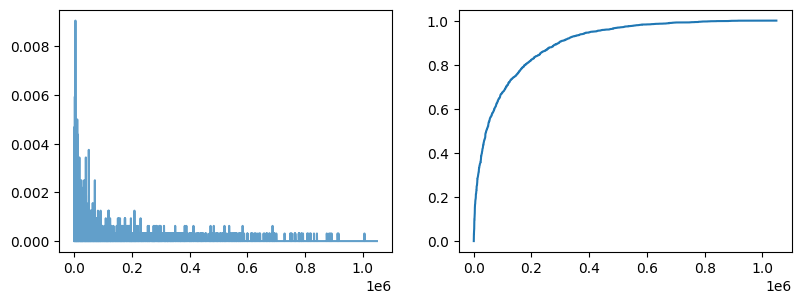

In [15]:
%matplotlib
cm = 1/2.54
# PDF plot
fig, axs = plt.subplots(1, 2, figsize=(24*cm, 8*cm))
sorted_idx = np.argsort(-prob_baseline)
pdf_best = np.array(prob_best)[sorted_idx]
cdf_best = np.cumsum(pdf_best)
axs[0].plot(pdf_best, label='Best', c='tab:blue', alpha=0.7)
axs[1].plot(cdf_best, label='Best', c='tab:blue')
fig

In [16]:
prob_hamming1 = hamming1_scatter(prob_baseline, prob_best, num_qubits)

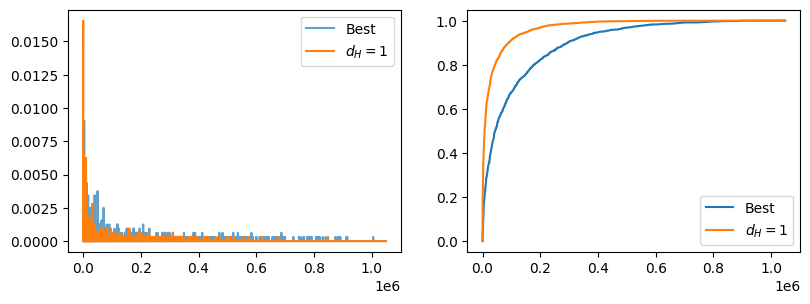

In [17]:
pdf_hamming1 = np.array(prob_hamming1)[sorted_idx]
cdf_hamming1 = np.cumsum(prob_hamming1[sorted_idx])
axs[0].plot(pdf_hamming1, label = r'$d_H=1$', c= 'tab:orange')
axs[1].plot(cdf_hamming1, label = r'$d_H=1$', c= 'tab:orange')
for ax in axs:
    ax.legend()
fig

In [18]:
plt.close(fig)

Examples of the generated circuits

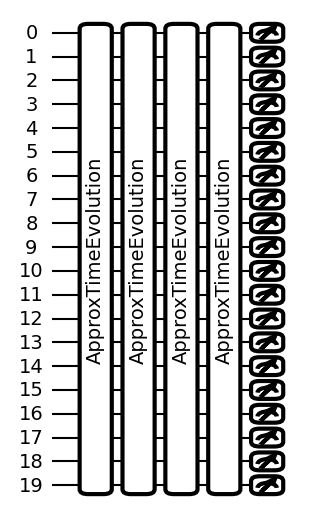

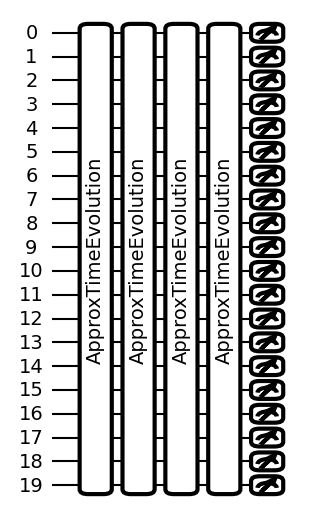

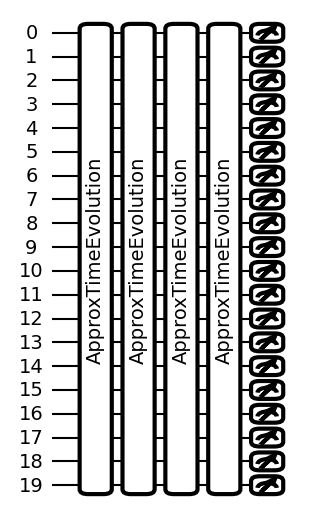

In [19]:
%matplotlib inline
import pennylane as qml
import matplotlib.pyplot as plt

num_sampled_qc = 3  # number of quantum circuits to be drawn out of num_seq.

@qml.qnode(device=operators.dev)
def distribution_circuit(ops):
    # apply all randomly chosen ops from the pool.
    for layer in ops:
        qml.apply(layer)
    # return sampled results as dict.
    return qml.counts()

for ops in gen_op_seq_best[:num_sampled_qc]:
    fig, ax = qml.draw_mpl(distribution_circuit, level="gradient")(ops)
    fig.set_size_inches(3, 5)